In [1]:
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt

2024-05-24 11:31:25.717491: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [24]:
def get_mutual_distance(batch: tf.Tensor) -> tf.Tensor:
    """See: https://stackoverflow.com/a/37040451"""
    # Compute distance square.
    r = tf.reduce_sum(tf.square(batch), axis=1)
    r = tf.reshape(r, [-1, 1])
    dist_square = r - 2 * tf.matmul(batch, tf.transpose(batch)) + tf.transpose(r)
    # Compute distance.
    dist_square = tf.where(dist_square < 0, tf.zeros_like(dist_square), dist_square)
    return tf.sqrt(dist_square)

In [25]:
def get_neighbours(x: tf.Tensor, num_nb: int) -> tf.Tensor:
    dist = get_mutual_distance(x)
    return tf.math.top_k(-dist, num_nb+1)[1][:, 1:]

In [26]:
def get_dynamics(num_nb: int, J: float, dt: float, T: float):
    @tf.function
    def dynamics(x: tf.Tensor, v: tf.Tensor):
        nb = get_neighbours(x, num_nb)
        nb_v = tf.gather(v, nb, axis=0)
        v += J * (tf.reduce_mean(nb_v, axis=1) - v) * dt
        v += tf.random.normal(tf.shape(v)) * tf.sqrt(2*T*dt)
        x += v * dt
        return x, v
    return dynamics

dynamics = get_dynamics(5, 1e+1, 1e-2, 1e-1)

In [27]:
x = tf.random.uniform([1000, 3])
v = tf.random.uniform([1000, 3])

for _ in tqdm(range(3000)):
    x, v = dynamics(x, v)

100%|██████████████████████████████████████████████████████| 3000/3000 [00:07<00:00, 388.78it/s]


In [28]:
v, x

(<tf.Tensor: shape=(1000, 3), dtype=float32, numpy=
 array([[ 0.5435019 , -0.92760694,  1.4264784 ],
        [-0.82650614,  0.52262145, -0.47103587],
        [ 0.20280771,  0.7534862 , -0.7842557 ],
        ...,
        [ 0.5779882 , -0.0708055 ,  0.76394856],
        [ 0.18462366,  0.664624  ,  0.12583356],
        [ 0.25796753,  1.00536   , -0.15685007]], dtype=float32)>,
 <tf.Tensor: shape=(1000, 3), dtype=float32, numpy=
 array([[ 18.68617  ,  -1.6713   ,  29.39906  ],
        [-15.476074 ,   8.300952 ,  -6.5593567],
        [  9.876423 ,  15.785485 ,   2.2921526],
        ...,
        [ 20.333317 ,  -3.5407214,  30.126661 ],
        [ 22.728191 ,  10.767985 ,  18.786856 ],
        [  8.831775 ,  34.730206 ,  -5.0739064]], dtype=float32)>)

In [35]:
def binning(x: np.ndarray, y: np.ndarray, num_bins: int, agg_fn=np.mean, eps=1e-1):
    x_min = x.min()
    x_max = x.max()
    num_x = len(x)
    bins = np.linspace(x_min, x_max, num_bins+1)
    x_bin = [x_min]
    y_agg = []
    y_cache = []
    hist = []
    i = 0
    for (j, xj) in enumerate(x):
        if j == num_x - 1 or xj >= bins[i+1]:
            i += 1
            if not y_cache:
                continue
            else:
                x_bin.append(xj)
                y_agg.append(agg_fn(y_cache))
                hist.append(len(y_cache))
                y_cache = []
        else:
            y_cache.append(y[j])
    return x_bin, y_agg, hist

1000000it [00:00, 1353693.42it/s]


In [45]:
def get_zeta_and_supp(x, v, num_bins):
    dist = get_mutual_distance(x)
    dist = tf.reshape(dist, [-1])

    v_mean = tf.reduce_mean(v, axis=0, keepdims=True)
    u = v - v_mean
    inner_u = tf.matmul(u, tf.transpose(u))
    inner_u = tf.reshape(inner_u, [-1])

    # Sort by distance
    ids = tf.argsort(dist, axis=0)
    sorted_inner_u = tf.gather(inner_u, ids)
    sorted_dist = tf.gather(dist, ids)

    r_bin, u_mean, hist = binning(sorted_dist.numpy(), sorted_inner_u.numpy(), num_bins)
    zeta = r_bin[tf.argmin(tf.square(u_mean))]
    return zeta, (sorted_dist, sorted_inner_u, r_bin, u_mean, hist)


zeta, (sorted_dist, sorted_inner_u, r_bin, u_mean, hist) = get_zeta_and_supp(x, v, 50)
zeta

1000000it [00:00, 1359478.55it/s]


31.395947

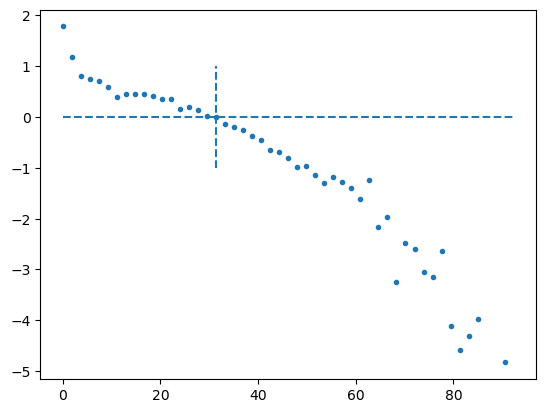

In [46]:
plt.scatter(r_bin[:-1], u_mean, marker='.')
plt.hlines(0, xmin=sorted_dist[0], xmax=sorted_dist[-1], linestyles='--')
plt.vlines(zeta, ymin=-1, ymax=1, linestyles='--')
plt.show()

In [76]:
def get_group_size(x):
    dist = tf.reshape(get_mutual_distance(x), [-1])
    return tf.reduce_max(dist)

In [104]:
def check_scale_free(dynamics, min_n, max_n,
                     num_n=10, num_repeats=12,
                     iter_steps=5000, num_bins=50):
    group_sizes, zetas = [], []
    for log2_n in tqdm(np.linspace(np.log2(min_n), np.log2(max_n), num_n)):
        n = int(2**log2_n)
        group_sizes.append([])
        zetas.append([])
        for _ in range(num_repeats):
            x = tf.random.uniform([n, 3])
            v = tf.random.uniform([n, 3])
        
            for _ in range(iter_steps):
                x, v = dynamics(x, v)

            group_size = get_group_size(x)
            group_sizes[-1].append(group_size)

            zeta, _ = get_zeta_and_supp(x, v, num_bins)
            zetas[-1].append(zeta)
    return group_sizes, zetas


def plot_check(group_sizes, zetas):
    zeta_means = [np.mean(_) for _ in zetas]
    zeta_stds = [np.std(_) for _ in zetas]
    group_size_means = [np.mean(_) for _ in group_sizes]
    group_size_stds = [np.std(_) for _ in group_sizes]
    plt.errorbar(x=group_size_means, xerr=group_size_stds,
                 y=zeta_means, yerr=zeta_stds,
                 capsize=3, fmt="ro", ecolor = "black")
    plt.xlabel('Group Size')
    plt.ylabel('Correlation Length')
    plt.show()

In [84]:
dynamics = get_dynamics(num_nb=7, J=0.1, dt=0.01, T=0.1)
group_sizes, zetas = check_scale_free(dynamics, min_n=30, max_n=1000)

100%|█████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 4020.43it/s]
900it [00:00, 466091.32it/s]
100%|█████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 3829.68it/s]
900it [00:00, 463629.77it/s]
100%|█████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 3859.79it/s]
900it [00:00, 460182.08it/s]
100%|█████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 3832.59it/s]
900it [00:00, 441299.23it/s]
100%|█████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 3475.00it/s]
900it [00:00, 440835.41it/s]
100%|█████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 3322.82it/s]
900it [00:00, 372900.68it/s]
100%|█████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 3270.90it/s]
900it [00:00, 412374.22it/s]
100%|█████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 3184.23it/s]
900it [00:00, 325925.

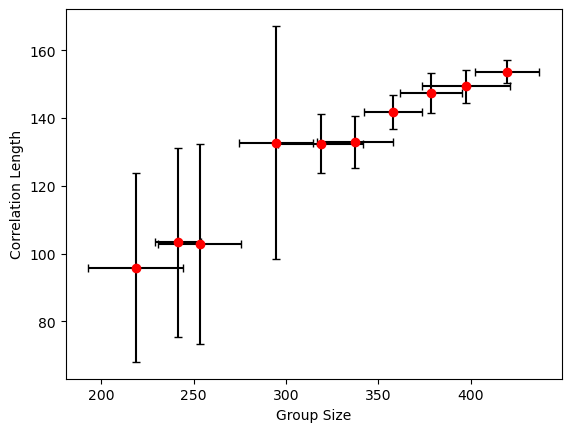

In [105]:
plot_check(group_sizes, zetas)